In [1]:
#!/usr/bin/env python
# coding: utf-8

# ### 기본 라이브러리 설정

# In[1]:


# 라이브러리 정의 import tensorflow.keras
#import keras
from tensorflow import keras
#from keras import layers
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


script_dir = os.getcwd() # os.path.dirname(__file__)
results_dir = os.path.join(script_dir, 'Results/')


warnings.filterwarnings(action="ignore")

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

# ### 1~2. 데이터 불러오기 및 분리

# In[4]:

In [2]:
# 데이터 불러오기 및 정렬
featureData = pd.read_csv('../dataset/t1471oboccurs.csv')
sortKey = ["shcode","date","time"]

featureData = featureData.sort_values(sortKey)
featureData.head()
# 숫자형 컬럼 생성
#featureData["HOLIDAY_YN"] = np.where(featureData.HOLIDAY=="Y",1,0)
#featureData["PROMOTION_YN"] = np.where(featureData.PROMOTION=="Y",1,0)

,shcode,date,time,preoffercha1,offerrem1,offerho1,bidho1,bidrem1,prebidcha1,totofferrem,totbidrem,totsun,msrate,close
18999,270,20201026,90200,0,1701,46300,46250,2325,0,15671,18704,3033,119.35,46300
18998,270,20201026,90300,2769,4470,46300,46250,1486,-839,17128,22847,5719,133.39,46250
18997,270,20201026,90400,0,1163,46200,46150,3133,0,26369,21745,-4624,82.46,46150
18996,270,20201026,90500,0,1638,45850,45800,1510,0,15902,19141,3239,120.37,45800
18995,270,20201026,90600,0,39,45800,45750,1788,0,10038,21448,11410,213.67,45750


In [3]:
# In[10]:


# 특정 주차 기준 분리
predictStd = 150000
train_dataset = featureData[(featureData.time <= predictStd) & (featureData.shcode == 270)]
test_dataset = featureData[(featureData.time > predictStd) & (featureData.shcode == 270)]


# 특정 주차 기준 분리
# predictStd = 201630
# train_dataset = featureData.query('YEARWEEK <= @predictStd')
# test_dataset = featureData.query('YEARWEEK > @predictStd’)
print(train_dataset.head())

       shcode      date   time  preoffercha1  offerrem1  offerho1  bidho1  \
18999     270  20201026  90200             0       1701     46300   46250   
18998     270  20201026  90300          2769       4470     46300   46250   
18997     270  20201026  90400             0       1163     46200   46150   
18996     270  20201026  90500             0       1638     45850   45800   
18995     270  20201026  90600             0         39     45800   45750   

       bidrem1  prebidcha1  totofferrem  totbidrem  totsun  msrate  close  
18999     2325           0        15671      18704    3033  119.35  46300  
18998     1486        -839        17128      22847    5719  133.39  46250  
18997     3133           0        26369      21745   -4624   82.46  46150  
18996     1510           0        15902      19141    3239  120.37  45800  
18995     1788           0        10038      21448   11410  213.67  45750  


In [4]:
# 인덱스 초기화
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

# 답지 별도 분리
train_labels = train_dataset["close"]
test_labels = test_dataset["close"]
train_dataset.head()

,shcode,date,time,preoffercha1,offerrem1,offerho1,bidho1,bidrem1,prebidcha1,totofferrem,totbidrem,totsun,msrate,close
0,270,20201026,90200,0,1701,46300,46250,2325,0,15671,18704,3033,119.35,46300
1,270,20201026,90300,2769,4470,46300,46250,1486,-839,17128,22847,5719,133.39,46250
2,270,20201026,90400,0,1163,46200,46150,3133,0,26369,21745,-4624,82.46,46150
3,270,20201026,90500,0,1638,45850,45800,1510,0,15902,19141,3239,120.37,45800
4,270,20201026,90600,0,39,45800,45750,1788,0,10038,21448,11410,213.67,45750


In [5]:
# In[12]:


test_dataset.head()

,shcode,date,time,preoffercha1,offerrem1,offerho1,bidho1,bidrem1,prebidcha1,totofferrem,totbidrem,totsun,msrate,close
0,270,20201026,150100,-226,6663,48000,47950,2153,985,83451,26868,-56583,32.20,48000
1,270,20201026,150200,0,2282,47950,47900,4749,0,82731,29585,-53146,35.76,47950
2,270,20201026,150300,0,223,47900,47850,4519,0,76087,30750,-45337,40.41,47900
3,270,20201026,150400,0,2884,47950,47900,3584,0,84405,29949,-54456,35.48,47950
4,270,20201026,150500,-1468,1416,47950,47900,2454,-1130,86162,29350,-56812,34.06,47950


In [6]:
# In[13]:


train_dataset.columns

Index(['shcode', 'date', 'time', 'preoffercha1', 'offerrem1', 'offerho1',
       'bidho1', 'bidrem1', 'prebidcha1', 'totofferrem', 'totbidrem', 'totsun',
       'msrate', 'close'],
      dtype='object')

In [7]:
# In[14]:


# feature / label 선정 다른 풀이
# label = ["QTY"]
# features = list(featuresData.select_dtypes(np.number).columns)
# features = list(set(features)-set(label))


# In[16]:


features  = ["close"]
#label = ['close']


# In[17]:

train_dataset = train_dataset.dropna()
test_dataset = test_dataset.dropna()

trainingData_features = train_dataset[features]
trainingData_features

,close
0,46300
1,46250
2,46150
3,45800
4,45750
...,...
354,47950
355,47950
356,47950
357,48050


In [8]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(trainingData_features)
df_scaled

array([[0.27777778],
       [0.25925926],
       [0.22222222],
       [0.09259259],
       [0.07407407],
       [0.        ],
       [0.11111111],
       [0.11111111],
       [0.12962963],
       [0.12962963],
       [0.12962963],
       [0.18518519],
       [0.2037037 ],
       [0.25925926],
       [0.2962963 ],
       [0.37037037],
       [0.40740741],
       [0.46296296],
       [0.46296296],
       [0.42592593],
       [0.48148148],
       [0.51851852],
       [0.51851852],
       [0.46296296],
       [0.42592593],
       [0.40740741],
       [0.35185185],
       [0.38888889],
       [0.40740741],
       [0.31481481],
       [0.35185185],
       [0.2962963 ],
       [0.2962963 ],
       [0.2962963 ],
       [0.2962963 ],
       [0.27777778],
       [0.24074074],
       [0.22222222],
       [0.22222222],
       [0.22222222],
       [0.18518519],
       [0.2037037 ],
       [0.25925926],
       [0.25925926],
       [0.25925926],
       [0.25925926],
       [0.25925926],
       [0.203

In [9]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['close']
df_scaled

,close
0,0.277778
1,0.259259
2,0.222222
3,0.092593
4,0.074074
...,...
354,0.888889
355,0.888889
356,0.888889
357,0.925926


In [10]:
trainingData_features = df_scaled
trainingData_features

,close
0,0.277778
1,0.259259
2,0.222222
3,0.092593
4,0.074074
...,...
354,0.888889
355,0.888889
356,0.888889
357,0.925926


In [11]:
# trainingData_label = train_dataset[label]
testData_features = test_dataset[features]
# testData_label = test_dataset[label]
df_scaled = scaler.fit_transform(testData_features)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['close']
testData_features = df_scaled
testData_features

,close
0,0.50
1,0.25
2,0.00
3,0.25
4,0.25
5,0.25
6,0.50
7,0.50
8,0.75
9,0.50


In [25]:
testData_all = test_dataset

for s in range(1, 13):
    trainingData_features['shift_{}'.format(s)] = trainingData_features['close'].shift(s)
    testData_features['shift_{}'.format(s)] = testData_features['close'].shift(s)

trainingData_features.head()


,close,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
0,0.394924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.394924,0.394924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.394924,0.394924,0.394924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.394924,0.394924,0.394924,0.394924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.394924,0.394924,0.394924,0.394924,0.394924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#결측치 대체
#trainingData_features = trainingData_features.where(pd.isnull(trainingData_features), trainingData_features.mean(), axis='columns')
trainingData_features = trainingData_features.fillna(trainingData_features.mean())
trainingData_features
# 출처: https://rfriend.tistory.com/262 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

,close,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
0,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
1,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
2,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
3,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
4,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
355,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
356,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
357,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924


In [27]:
#결측치 대체
#trainingData_features = trainingData_features.where(pd.isnull(trainingData_features), trainingData_features.mean(), axis='columns')
testData_features = testData_features.fillna(trainingData_features.mean())
testData_features
# 출처: https://rfriend.tistory.com/262 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

,close,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
0,0.50,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
1,0.25,0.500000,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
2,0.00,0.250000,0.500000,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
3,0.25,0.000000,0.250000,0.500000,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
4,0.25,0.250000,0.000000,0.250000,0.500000,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
5,0.25,0.250000,0.250000,0.000000,0.250000,0.500000,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
6,0.50,0.250000,0.250000,0.250000,0.000000,0.250000,0.500000,0.394924,0.394924,0.394924,0.394924,0.394924,0.394924
7,0.50,0.500000,0.250000,0.250000,0.250000,0.000000,0.250000,0.500000,0.394924,0.394924,0.394924,0.394924,0.394924
8,0.75,0.500000,0.500000,0.250000,0.250000,0.250000,0.000000,0.250000,0.500000,0.394924,0.394924,0.394924,0.394924
9,0.50,0.750000,0.500000,0.500000,0.250000,0.250000,0.250000,0.000000,0.250000,0.500000,0.394924,0.394924,0.394924


In [28]:
tempTrData = trainingData_features

trainingData_features = tempTrData.dropna().drop('close', axis=1)
trainingData_label = tempTrData.dropna()[['close']]
# print("---------------------------")
# print(trainingData_features.head())
# print("---------------------------")
# print(trainingData_label.head)

In [29]:
print(testData_features)
tempTsData = testData_features.dropna()

    close   shift_1   shift_2   shift_3   shift_4   shift_5   shift_6  \
0    0.50  0.394924  0.394924  0.394924  0.394924  0.394924  0.394924   
1    0.25  0.500000  0.394924  0.394924  0.394924  0.394924  0.394924   
2    0.00  0.250000  0.500000  0.394924  0.394924  0.394924  0.394924   
3    0.25  0.000000  0.250000  0.500000  0.394924  0.394924  0.394924   
4    0.25  0.250000  0.000000  0.250000  0.500000  0.394924  0.394924   
5    0.25  0.250000  0.250000  0.000000  0.250000  0.500000  0.394924   
6    0.50  0.250000  0.250000  0.250000  0.000000  0.250000  0.500000   
7    0.50  0.500000  0.250000  0.250000  0.250000  0.000000  0.250000   
8    0.75  0.500000  0.500000  0.250000  0.250000  0.250000  0.000000   
9    0.50  0.750000  0.500000  0.500000  0.250000  0.250000  0.250000   
10   0.50  0.500000  0.750000  0.500000  0.500000  0.250000  0.250000   
11   0.50  0.500000  0.500000  0.750000  0.500000  0.500000  0.250000   
12   0.50  0.500000  0.500000  0.500000  0.750000  

In [30]:
# print(tempTsData)
testData_features = tempTsData.drop('close', axis=1)
testData_label = tempTsData[['close']]
# print(testData_features.head())
# print(test_labels.head())
print(testData_features)

     shift_1   shift_2   shift_3   shift_4   shift_5   shift_6   shift_7  \
0   0.394924  0.394924  0.394924  0.394924  0.394924  0.394924  0.394924   
1   0.500000  0.394924  0.394924  0.394924  0.394924  0.394924  0.394924   
2   0.250000  0.500000  0.394924  0.394924  0.394924  0.394924  0.394924   
3   0.000000  0.250000  0.500000  0.394924  0.394924  0.394924  0.394924   
4   0.250000  0.000000  0.250000  0.500000  0.394924  0.394924  0.394924   
5   0.250000  0.250000  0.000000  0.250000  0.500000  0.394924  0.394924   
6   0.250000  0.250000  0.250000  0.000000  0.250000  0.500000  0.394924   
7   0.500000  0.250000  0.250000  0.250000  0.000000  0.250000  0.500000   
8   0.500000  0.500000  0.250000  0.250000  0.250000  0.000000  0.250000   
9   0.750000  0.500000  0.500000  0.250000  0.250000  0.250000  0.000000   
10  0.500000  0.750000  0.500000  0.500000  0.250000  0.250000  0.250000   
11  0.500000  0.500000  0.750000  0.500000  0.500000  0.250000  0.250000   
12  0.500000

In [31]:
trainingData_features = trainingData_features.values
trainingData_label = trainingData_label.values
testData_features = testData_features.values
testData_label = testData_label.values
print(testData_features)

[[0.39492417 0.39492417 0.39492417 0.39492417 0.39492417 0.39492417
  0.39492417 0.39492417 0.39492417 0.39492417 0.39492417 0.39492417]
 [0.5        0.39492417 0.39492417 0.39492417 0.39492417 0.39492417
  0.39492417 0.39492417 0.39492417 0.39492417 0.39492417 0.39492417]
 [0.25       0.5        0.39492417 0.39492417 0.39492417 0.39492417
  0.39492417 0.39492417 0.39492417 0.39492417 0.39492417 0.39492417]
 [0.         0.25       0.5        0.39492417 0.39492417 0.39492417
  0.39492417 0.39492417 0.39492417 0.39492417 0.39492417 0.39492417]
 [0.25       0.         0.25       0.5        0.39492417 0.39492417
  0.39492417 0.39492417 0.39492417 0.39492417 0.39492417 0.39492417]
 [0.25       0.25       0.         0.25       0.5        0.39492417
  0.39492417 0.39492417 0.39492417 0.39492417 0.39492417 0.39492417]
 [0.25       0.25       0.25       0.         0.25       0.5
  0.39492417 0.39492417 0.39492417 0.39492417 0.39492417 0.39492417]
 [0.5        0.25       0.25       0.25       0.

In [32]:
# In[18]:
#trainingData_features = np.reshape(trainingData_features, (trainingData_features.shape[0], 12, len(features))) # 샘플 수, 타임스텝 수, 속성 수
trainingData_features = trainingData_features.reshape(trainingData_features.shape[0],  12,1) # 각각의 차원은 (size, timestep, feature)
trainingData_features = K.cast(trainingData_features, dtype='float64')
trainingData_label = K.cast(trainingData_label, dtype = 'float64')
print(trainingData_features.shape)
print("---------------------------")
print(trainingData_features)
print("---------------------------")
print(trainingData_label)

(359, 12, 1)
---------------------------
tf.Tensor(
[[[0.39492417]
  [0.39492417]
  [0.39492417]
  ...
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.39492417]
  [0.39492417]
  [0.39492417]
  ...
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.39492417]
  [0.39492417]
  [0.39492417]
  ...
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 ...

 [[0.39492417]
  [0.39492417]
  [0.39492417]
  ...
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.39492417]
  [0.39492417]
  [0.39492417]
  ...
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.39492417]
  [0.39492417]
  [0.39492417]
  ...
  [0.39492417]
  [0.39492417]
  [0.39492417]]], shape=(359, 12, 1), dtype=float64)
---------------------------
tf.Tensor(
[[0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]
 [0.39492417]

In [33]:
# print(trainingData_features)
testData_features = testData_features.reshape(testData_features.shape[0], 12,1) # 각각의 차원은 (size, timestep, feature)
testData_features = K.cast(testData_features, dtype='float64')
testData_label = K.cast(testData_label, dtype='float64')
print(testData_features.shape)
print("---------------------------")
print(testData_features)
print("---------------------------")
print(testData_label)
# print(testData_features.shape)
# print(testData_features)
# ### 3. 모델 생성

# In[19]:

(21, 12, 1)
---------------------------
tf.Tensor(
[[[0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.5       ]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.25      ]
  [0.5       ]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.        ]
  [0.25      ]
  [0.5       ]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.25      ]
  [0.        ]
  [0.25      ]
  [0.5       ]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.25      ]
  [0.25      ]
  [0.    

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


# In[22]:


trainingData_features.shape
#print(len(features))


# In[23]:

K.clear_session
model = Sequential()
### 4개의 feature 가 행으로 입력됨
# model.add(Dense(8, activation='relu', input_shape=(len(features),)))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1))

model.add(LSTM(20, input_shape=(12,1))) # (timestep, feature)

#model.add(LSTM(20, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

# ### 4. 모델 컴파일
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [35]:
# ### 5. 모델 훈련

# In[25]:


from tensorflow.keras.callbacks import EarlyStopping
#더이상 에러율이 향상되지 않을 시 정지한다, 단 patience 옵션 유지(너무빨리 끝나는거 방지)
# early_stopping_monitor = EarlyStopping(patience=500)

early_stopping_monitor = EarlyStopping(monitor='loss', patience=1, verbose=1)
EPOCHS = 50
#모델 훈련 (훈련/검증을 80%, 20%로 나눔)
# history =model.fit(trainingData_features,
#                    trainingData_label,
#                    validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

history = model.fit(trainingData_features, trainingData_label, epochs=EPOCHS, batch_size=30, validation_split=0.2, verbose=1, callbacks=[early_stopping_monitor])

Train on 287 samples, validate on 72 samples
Epoch 1/50
287/287 [==============================] - 3s 11ms/sample - loss: 0.0926 - val_loss: 0.0524
Epoch 2/50
287/287 [==============================] - 0s 608us/sample - loss: 0.0310 - val_loss: 0.0089
Epoch 3/50
287/287 [==============================] - 0s 607us/sample - loss: 0.0026 - val_loss: 9.9333e-04
Epoch 4/50
287/287 [==============================] - 0s 597us/sample - loss: 0.0022 - val_loss: 0.0016
Epoch 5/50
287/287 [==============================] - 0s 604us/sample - loss: 5.1964e-04 - val_loss: 3.2120e-05
Epoch 6/50
287/287 [==============================] - 0s 609us/sample - loss: 1.8177e-04 - val_loss: 2.3348e-04
Epoch 7/50
287/287 [==============================] - 0s 609us/sample - loss: 1.1507e-04 - val_loss: 3.1527e-06
Epoch 8/50
287/287 [==============================] - 0s 596us/sample - loss: 1.1886e-05 - val_loss: 2.8168e-05
Epoch 9/50
287/287 [==============================] - 0s 606us/sample - loss: 1.6176e-05

       loss      val_loss
0  0.092631  5.244947e-02
1  0.030992  8.903921e-03
2  0.002637  9.933343e-04
3  0.002219  1.567229e-03
4  0.000520  3.212030e-05
5  0.000182  2.334841e-04
6  0.000115  3.152729e-06
7  0.000012  2.816793e-05
8  0.000016  8.345381e-07


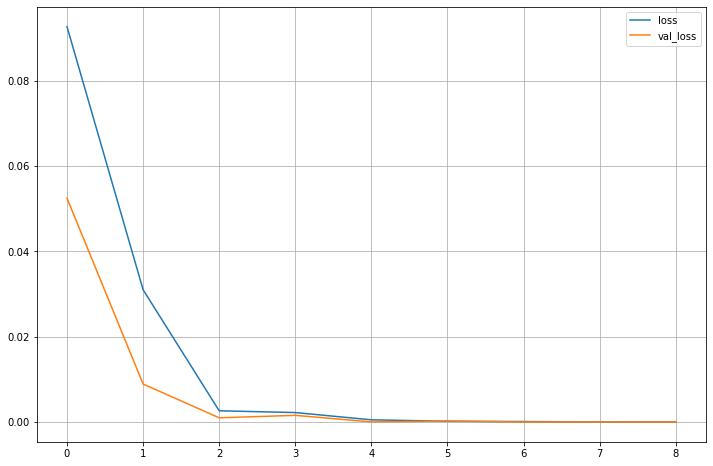

In [36]:
print(pd.DataFrame(history.history))
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')

plt.figure(figsize=(12,8))
# 훈련 데이터의 mse
plt.plot(history.history['loss'])
# 검증 데이터의 mse
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.grid()
#plt.show()
plt.savefig(results_dir+'figError.png', dpi=300)

In [37]:
# In[28]:


pd.DataFrame(history.history)


# ### 6. 모델 추론

# In[29]:


loss = model.evaluate(testData_features, testData_label, verbose=0)


# In[30]:


#model.evaluate(testData_features, testData_label, verbose=0)


# In[31]:


#np.sqrt(loss)


# ### 7. 예측

# In[35]:

print(testData_features)

tf.Tensor(
[[[0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.5       ]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.25      ]
  [0.5       ]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.        ]
  [0.25      ]
  [0.5       ]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.25      ]
  [0.        ]
  [0.25      ]
  [0.5       ]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]
  [0.39492417]]

 [[0.25      ]
  [0.25      ]
  [0.        ]
  [0.25      ]
  [0.5       ]
  [0

In [38]:
test_predictions = model.predict(testData_features).flatten()
# print(test_predictions)
#test_predictions


# In[36]:


# 예측결과 별도 데이터프레임 생성
predictValues = pd.DataFrame(list(test_predictions), columns = ["PREDICT"])
print(predictValues)
predictValues = scaler.inverse_transform(predictValues)
predictValues

     PREDICT
0   0.395838
1   0.397757
2   0.395457
3   0.388069
4   0.383895
5   0.378970
6   0.373191
7   0.371008
8   0.368690
9   0.370842
10  0.369359
11  0.368175
12  0.367212
13  0.358862
14  0.373166
15  0.406049
16  0.419597
17  0.447136
18  0.467587
19  0.468672
20  0.472764


array([[47979.16753888],
       [47979.55130935],
       [47979.09145951],
       [47977.61385441],
       [47976.77900195],
       [47975.79400539],
       [47974.63813424],
       [47974.20150638],
       [47973.73803854],
       [47974.16841388],
       [47973.87177944],
       [47973.6349225 ],
       [47973.44245315],
       [47971.77231908],
       [47974.63319302],
       [47981.20984435],
       [47983.91934037],
       [47989.42728639],
       [47993.51733327],
       [47993.73440146],
       [47994.55283284]])

In [39]:
predictValues = pd.DataFrame(predictValues)
predictValues.columns = ['PREDICT']
predictValues = predictValues
predictValues

,PREDICT
0,47979.167539
1,47979.551309
2,47979.091460
3,47977.613854
4,47976.779002
5,47975.794005
6,47974.638134
7,47974.201506
8,47973.738039
9,47974.168414


In [40]:
# predictValues = pd.Series(test_predictions, name='PREDICT')
# print(predictValues)
# 예측결과 컬럼 생성
finalResult = pd.concat([testData_all,predictValues],axis=1)
print(finalResult)

    shcode      date    time  preoffercha1  offerrem1  offerho1  bidho1  \
0      270  20201026  150100          -226       6663     48000   47950   
1      270  20201026  150200             0       2282     47950   47900   
2      270  20201026  150300             0        223     47900   47850   
3      270  20201026  150400             0       2884     47950   47900   
4      270  20201026  150500         -1468       1416     47950   47900   
5      270  20201026  150600          3752       5168     47950   47900   
6      270  20201026  150700             0       9680     48000   47950   
7      270  20201026  150800          -873       8807     48000   47950   
8      270  20201026  150900             0      10598     48050   48000   
9      270  20201026  151000         -3492       7106     48050   48000   
10     270  20201026  151100             0       1530     48000   47950   
11     270  20201026  151200             0       7791     48050   48000   
12     270  20201026  151

In [41]:
# ### 8. 예측결과 비교 (시각화)
#finalResult = finalResult.dropna()
print(finalResult)

    shcode      date    time  preoffercha1  offerrem1  offerho1  bidho1  \
0      270  20201026  150100          -226       6663     48000   47950   
1      270  20201026  150200             0       2282     47950   47900   
2      270  20201026  150300             0        223     47900   47850   
3      270  20201026  150400             0       2884     47950   47900   
4      270  20201026  150500         -1468       1416     47950   47900   
5      270  20201026  150600          3752       5168     47950   47900   
6      270  20201026  150700             0       9680     48000   47950   
7      270  20201026  150800          -873       8807     48000   47950   
8      270  20201026  150900             0      10598     48050   48000   
9      270  20201026  151000         -3492       7106     48050   48000   
10     270  20201026  151100             0       1530     48000   47950   
11     270  20201026  151200             0       7791     48050   48000   
12     270  20201026  151

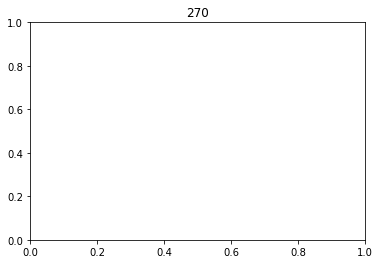

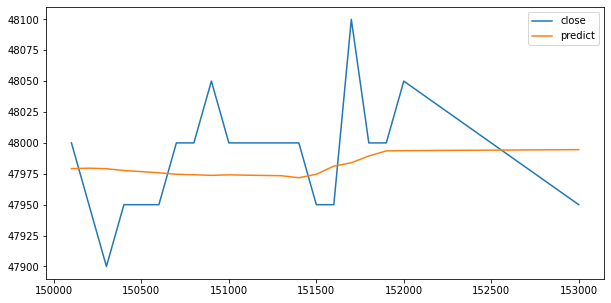

In [42]:
#finalResult.loc[0]
tempCodes = finalResult.drop_duplicates(['shcode'])
#tempCodes


# In[51]:


for code in tempCodes['shcode']:
    #print(code)
    plt.title(code)
    plt.figure(figsize=(10,5))
    plt.plot(finalResult.time[finalResult.shcode == code ], finalResult.close[finalResult.shcode == code], label = "close")
    plt.plot(finalResult.time[finalResult.shcode == code ], finalResult.PREDICT[finalResult.shcode == code], label = "predict")
    plt.legend(loc=0)
    plt.savefig(results_dir+'fig'+str(code)+'.png', dpi=300)



# ### 모델 저장 및 재학습

# In[53]:


# 모델 저장
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("linear_keras_sellout.h5")


# In[54]:


model.save("linear_keras_sellout2.h5")